- 라이브러리 불러오기

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import xgboost
import lightgbm
import warnings
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

- 데이터 확인

In [146]:
df = pd.read_csv('경진대회용 주조 공정최적화 데이터셋.csv', encoding='euc-kr')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,119,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B
2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B
3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,100,...,NaN,483.0,0.0,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B
4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,99,...,NaN,486.0,0.0,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B


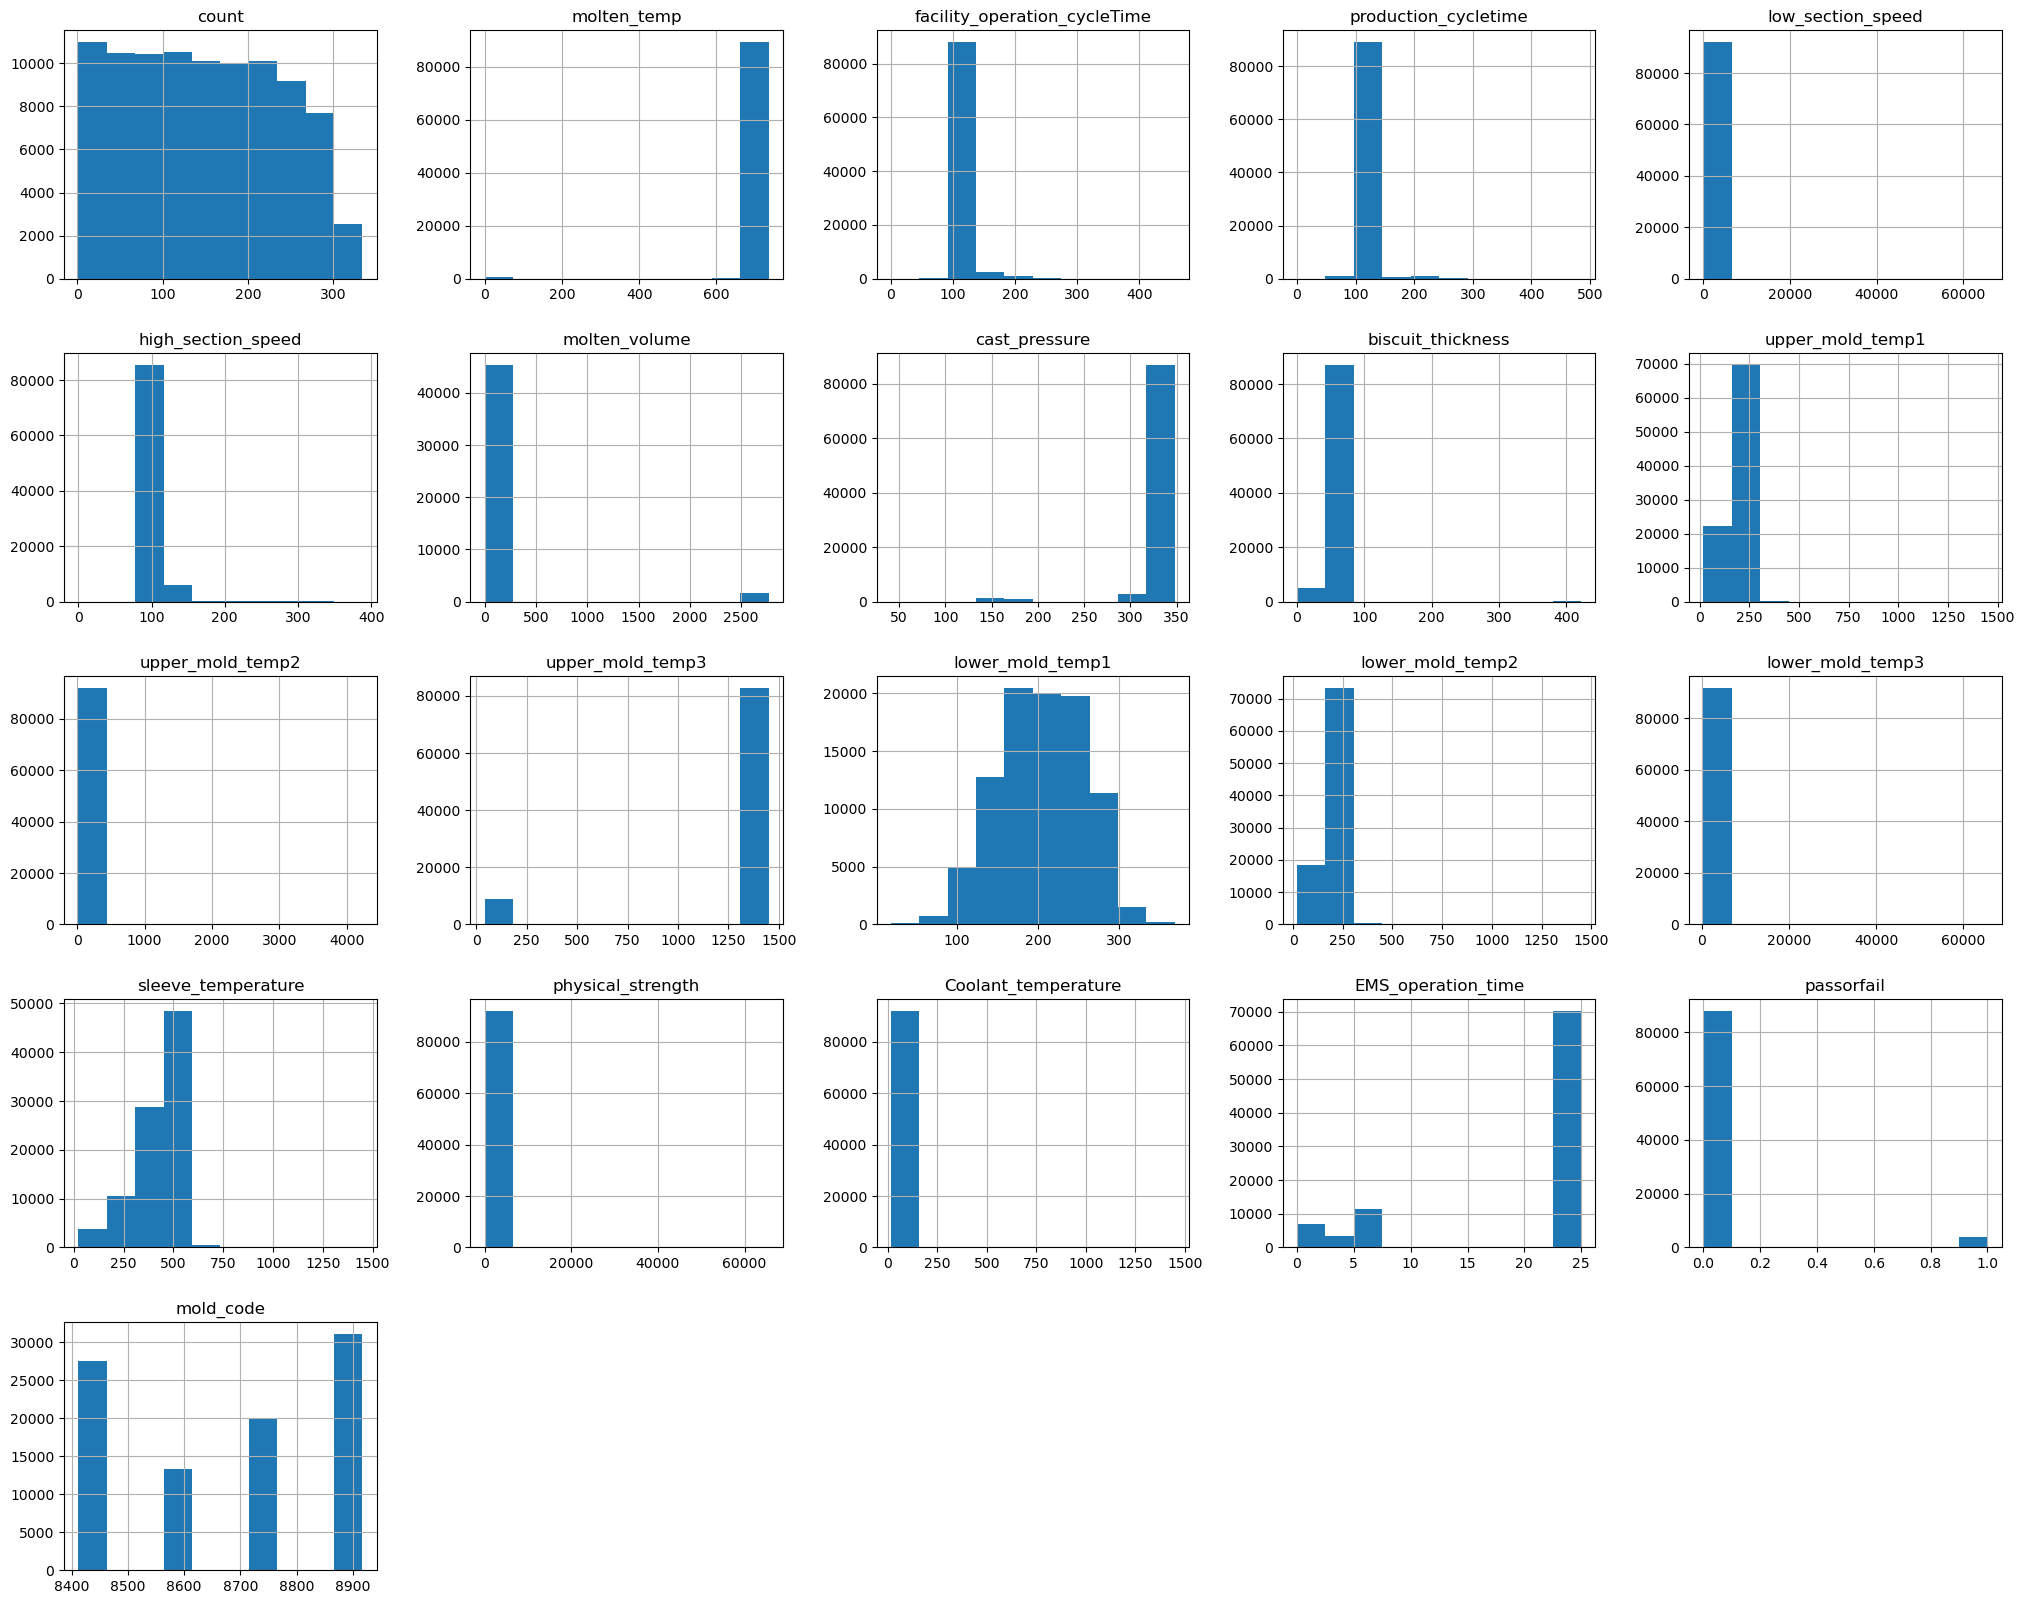

In [147]:
# 히스토그램 데이터 분포 확인
df.hist(figsize=(25,20))
plt.show()

In [148]:
num_pass = len(df[df['passorfail']==0])
num_fail = len(df[df['passorfail']==1])

print(f'pass : {num_pass}')
print(f'fail : {num_fail}')
print(f'불량률 : {num_fail/(num_pass+num_fail)*100} %')

pass : 87998
fail : 4016
불량률 : 4.364553220162149 %


In [149]:
df.columns, len(df.columns)

(Index(['line', 'name', 'mold_name', 'time', 'date', 'count', 'working',
        'emergency_stop', 'molten_temp', 'facility_operation_cycleTime',
        'production_cycletime', 'low_section_speed', 'high_section_speed',
        'molten_volume', 'cast_pressure', 'biscuit_thickness',
        'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
        'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
        'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
        'EMS_operation_time', 'registration_time', 'passorfail',
        'tryshot_signal', 'mold_code', 'heating_furnace'],
       dtype='object'),
 31)

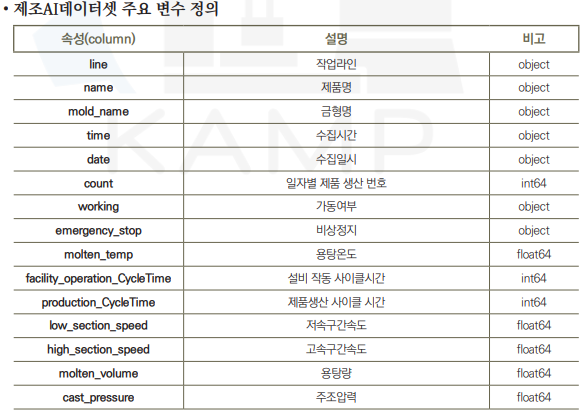
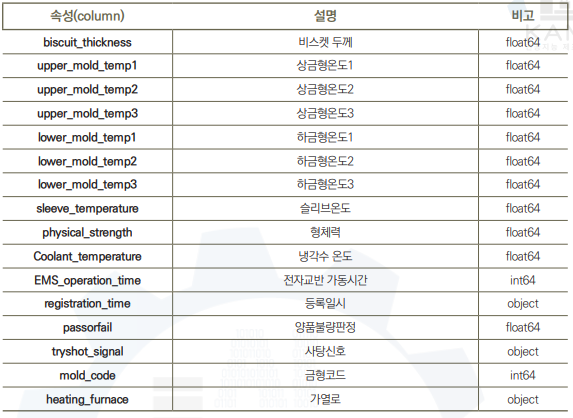

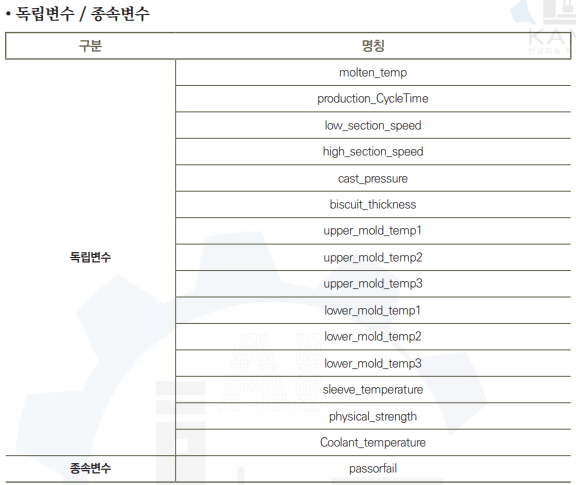

<Axes: >

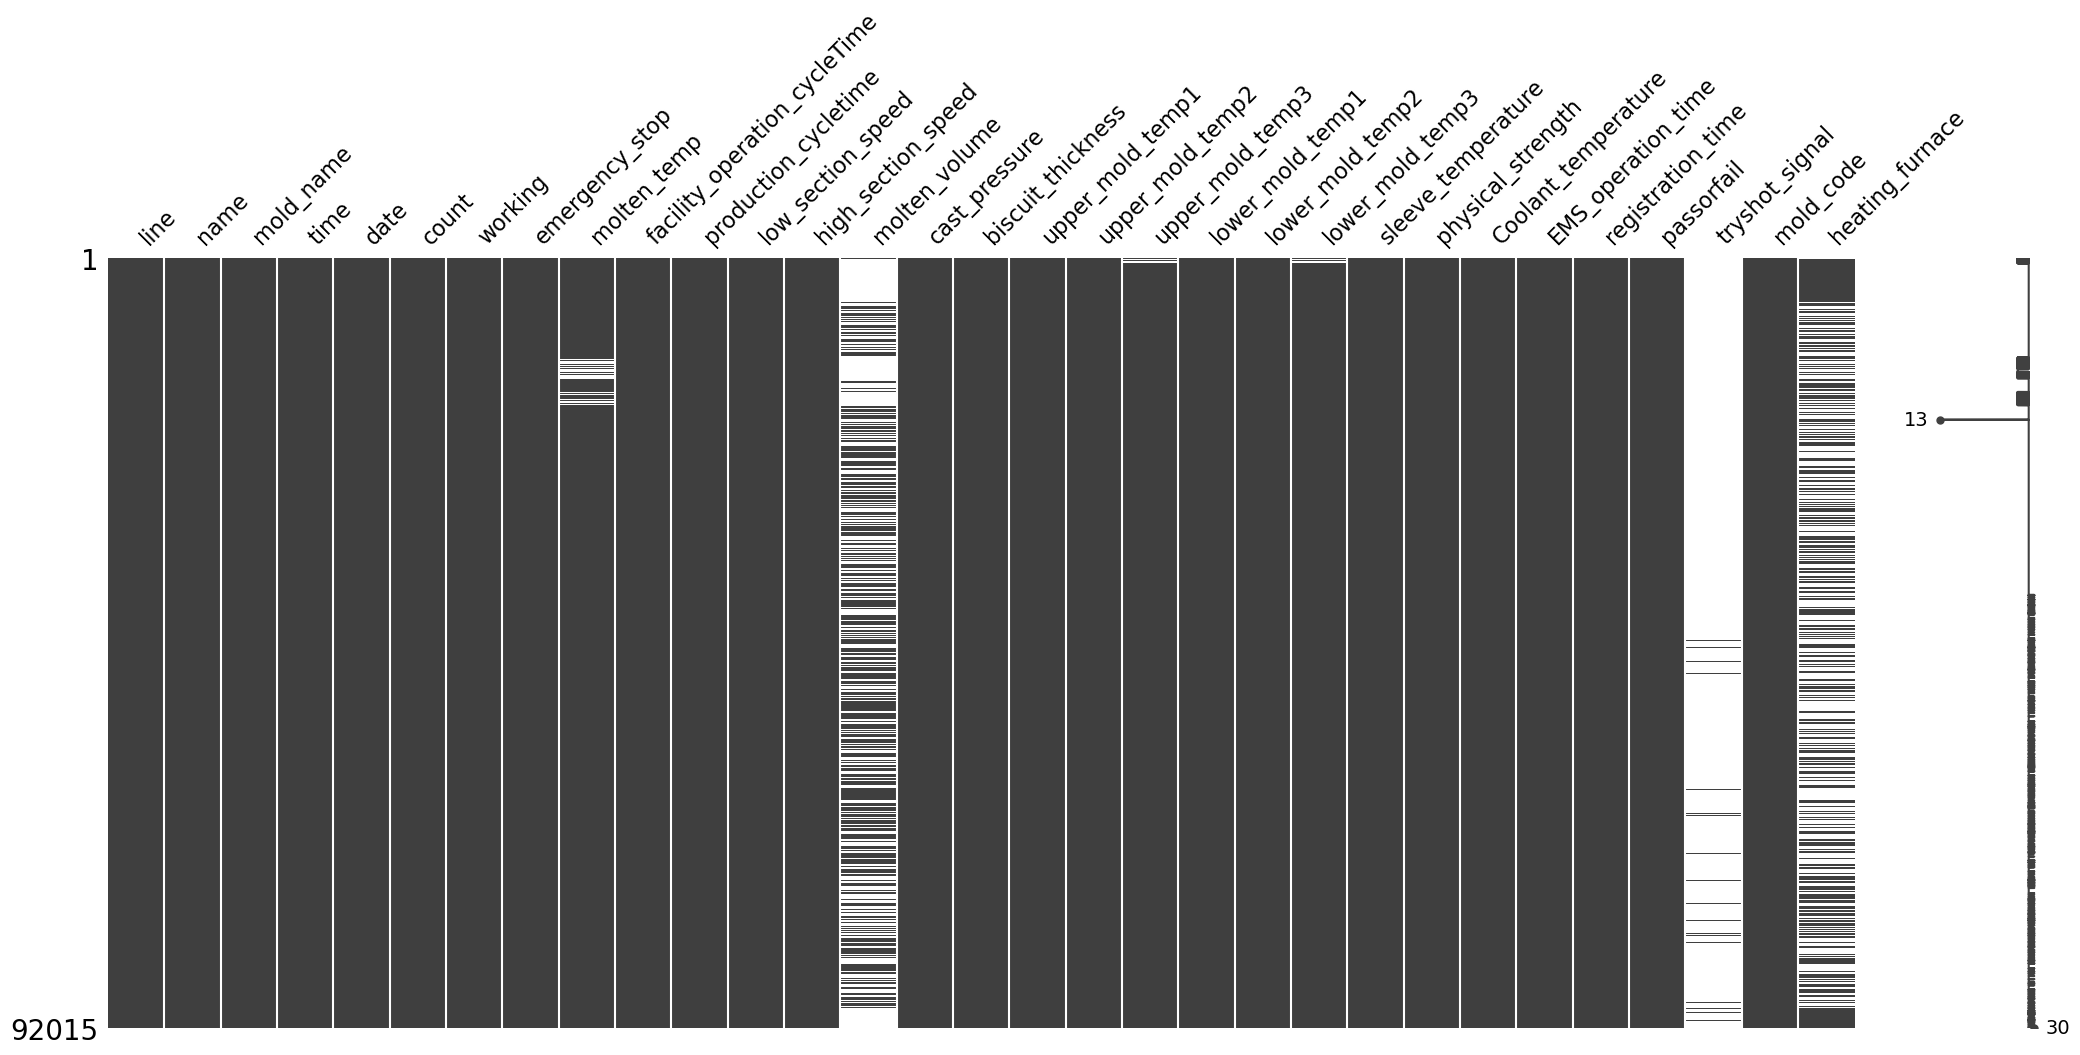

In [150]:
msno.matrix(df)

In [151]:
df.info()
# 총 92015 개 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92015 entries, 0 to 92014
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line                          92015 non-null  object 
 1   name                          92015 non-null  object 
 2   mold_name                     92015 non-null  object 
 3   time                          92015 non-null  object 
 4   date                          92015 non-null  object 
 5   count                         92015 non-null  int64  
 6   working                       92014 non-null  object 
 7   emergency_stop                92014 non-null  object 
 8   molten_temp                   89754 non-null  float64
 9   facility_operation_cycleTime  92015 non-null  int64  
 10  production_cycletime          92015 non-null  int64  
 11  low_section_speed             92014 non-null  float64
 12  high_section_speed            92014 non-null  float64
 13  m

In [152]:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 92015 entries, 0 to 92014
# Data columns (total 32 columns):
#  #   Column                        Non-Null Count  Dtype  
# ---  ------                        --------------  -----  
#  0   Unnamed: 0                    92015 non-null  int64  
#  1   line                          92015 non-null  object 
#  2   name                          92015 non-null  object 
#  3   mold_name                     92015 non-null  object 
#  4   time                          92015 non-null  object 
#  5   date                          92015 non-null  object 
#  6   count                         92015 non-null  int64  
#  7   working                       92014 non-null  object 
#  8   emergency_stop                92014 non-null  object 
#  9   molten_temp                   89754 non-null  float64
#  10  facility_operation_cycleTime  92015 non-null  int64  
#  11  production_cycletime          92015 non-null  int64  
#  12  low_section_speed             92014 non-null  float64
#  13  high_section_speed            92014 non-null  float64
#  14  molten_volume                 46885 non-null  float64
#  15  cast_pressure                 92014 non-null  float64
#  16  biscuit_thickness             92014 non-null  float64
#  17  upper_mold_temp1              92014 non-null  float64
#  18  upper_mold_temp2              92014 non-null  float64
#  19  upper_mold_temp3              91702 non-null  float64
#  20  lower_mold_temp1              92014 non-null  float64
#  21  lower_mold_temp2              92014 non-null  float64
#  22  lower_mold_temp3              91702 non-null  float64
#  23  sleeve_temperature            92014 non-null  float64
#  24  physical_strength             92014 non-null  float64
#  25  Coolant_temperature           92014 non-null  float64
#  26  EMS_operation_time            92015 non-null  int64  
#  27  registration_time             92015 non-null  object 
#  28  passorfail                    92014 non-null  float64
#  29  tryshot_signal                1919 non-null   object 
#  30  mold_code                     92015 non-null  int64  
#  31  heating_furnace               42869 non-null  object 
# dtypes: float64(16), int64(6), object(10)
# memory usage: 22.5+ MB

In [153]:
df.isna().sum()[df.isna().sum() > 0]

working                    1
emergency_stop             1
molten_temp             2261
low_section_speed          1
high_section_speed         1
molten_volume          45130
cast_pressure              1
biscuit_thickness          1
upper_mold_temp1           1
upper_mold_temp2           1
upper_mold_temp3         313
lower_mold_temp1           1
lower_mold_temp2           1
lower_mold_temp3         313
sleeve_temperature         1
physical_strength          1
Coolant_temperature        1
passorfail                 1
tryshot_signal         90096
heating_furnace        49146
dtype: int64

In [154]:
num_cols = df.dtypes[df.dtypes != object].index
num_df = df[num_cols]
num_df

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,molten_volume,cast_pressure,biscuit_thickness,upper_mold_temp1,...,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,731.0,119,120,110.0,112.0,75.0,331.0,35.0,198.0,...,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0,8722
1,243,720.0,98,125,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
2,244,721.0,98,122,109.0,109.0,NaN,309.0,48.0,250.0,...,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
3,245,721.0,100,125,112.0,109.0,NaN,308.0,49.0,268.0,...,NaN,211.0,179.0,NaN,483.0,0.0,30.0,25,0.0,8412
4,246,721.0,99,123,109.0,110.0,NaN,309.0,49.0,276.0,...,NaN,216.0,187.0,NaN,486.0,0.0,30.0,25,0.0,8412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,71,731.0,122,122,100.0,101.0,NaN,331.0,49.0,83.0,...,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
92011,72,731.0,120,121,100.0,101.0,NaN,331.0,54.0,83.0,...,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
92012,73,732.0,122,135,100.0,101.0,NaN,331.0,52.0,79.0,...,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
92013,74,732.0,133,122,100.0,101.0,NaN,331.0,53.0,82.0,...,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [155]:
num_df.isna().sum()[num_df.isna().sum() > 0]

molten_temp             2261
low_section_speed          1
high_section_speed         1
molten_volume          45130
cast_pressure              1
biscuit_thickness          1
upper_mold_temp1           1
upper_mold_temp2           1
upper_mold_temp3         313
lower_mold_temp1           1
lower_mold_temp2           1
lower_mold_temp3         313
sleeve_temperature         1
physical_strength          1
Coolant_temperature        1
passorfail                 1
dtype: int64

In [156]:
num_df.shape

(92015, 21)

In [157]:
# 2261/92015 # 0.024572080639026245
# 결측치가 30% 넘는 molten_volume만 제거
num_df = num_df.drop(columns='molten_volume')
num_df

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,731.0,119,120,110.0,112.0,331.0,35.0,198.0,116.0,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0,8722
1,243,720.0,98,125,109.0,109.0,309.0,48.0,250.0,113.0,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
2,244,721.0,98,122,109.0,109.0,309.0,48.0,250.0,113.0,NaN,208.0,163.0,NaN,481.0,0.0,30.0,25,0.0,8412
3,245,721.0,100,125,112.0,109.0,308.0,49.0,268.0,122.0,NaN,211.0,179.0,NaN,483.0,0.0,30.0,25,0.0,8412
4,246,721.0,99,123,109.0,110.0,309.0,49.0,276.0,128.0,NaN,216.0,187.0,NaN,486.0,0.0,30.0,25,0.0,8412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
92011,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
92012,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
92013,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [158]:
num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,92015.0,148.510895,87.969953,1.0,72.0,146.0,222.0,334.0
molten_temp,89754.0,718.618513,51.728659,0.0,713.0,728.0,730.0,735.0
facility_operation_cycleTime,92015.0,121.555007,12.116145,0.0,117.0,119.0,122.0,457.0
production_cycletime,92015.0,122.514525,13.595314,0.0,119.0,121.0,123.0,485.0
low_section_speed,92014.0,110.794999,305.181962,0.0,110.0,110.0,110.0,65535.0
high_section_speed,92014.0,112.624959,10.759272,0.0,112.0,112.0,112.0,388.0
cast_pressure,92014.0,324.554535,27.327683,41.0,329.0,330.0,331.0,348.0
biscuit_thickness,92014.0,50.666486,17.925620,0.0,47.0,50.0,53.0,422.0
upper_mold_temp1,92014.0,186.208870,46.041322,18.0,163.0,194.0,222.0,1449.0
upper_mold_temp2,92014.0,165.809203,31.654659,15.0,147.0,172.0,184.0,4232.0


In [159]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92015 entries, 0 to 92014
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   count                         92015 non-null  int64  
 1   molten_temp                   89754 non-null  float64
 2   facility_operation_cycleTime  92015 non-null  int64  
 3   production_cycletime          92015 non-null  int64  
 4   low_section_speed             92014 non-null  float64
 5   high_section_speed            92014 non-null  float64
 6   cast_pressure                 92014 non-null  float64
 7   biscuit_thickness             92014 non-null  float64
 8   upper_mold_temp1              92014 non-null  float64
 9   upper_mold_temp2              92014 non-null  float64
 10  upper_mold_temp3              91702 non-null  float64
 11  lower_mold_temp1              92014 non-null  float64
 12  lower_mold_temp2              92014 non-null  float64
 13  l

In [160]:
num_df = num_df.dropna()
num_df = num_df.reset_index(drop=True)
num_df

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
0,258,731.0,119,120,110.0,112.0,331.0,35.0,198.0,116.0,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0,8722
1,73,731.0,119,120,109.0,125.0,177.0,48.0,24.0,33.0,1449.0,30.0,273.0,1449.0,479.0,708.0,35.0,23,1.0,8722
2,1,731.0,119,123,109.0,112.0,176.0,49.0,26.0,55.0,1449.0,30.0,323.0,1449.0,513.0,700.0,35.0,23,1.0,8722
3,2,731.0,119,124,109.0,112.0,331.0,47.0,31.0,65.0,1449.0,30.0,343.0,1449.0,531.0,708.0,34.0,23,1.0,8722
4,3,731.0,120,124,110.0,112.0,331.0,46.0,36.0,73.0,1449.0,31.0,343.0,1449.0,544.0,707.0,34.0,23,1.0,8722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89436,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
89437,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
89438,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
89439,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


- 이상치 제거
    - 상하한 0.1%에 대한 이상치 제거함
    - IQR 적용시 불량 데이터가 너무 많이 제거됨

In [161]:
for col in num_df.columns:
 UCL = np.percentile(num_df[col], 99.9)
 LCL = np.percentile(num_df[col], 0.1)
 num_df = num_df[(num_df[col] <= UCL) & (num_df[col] >= LCL)]
num_df.reset_index()
num_df

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
33,32,729.0,127,128,109.0,112.0,330.0,45.0,142.0,74.0,1449.0,162.0,206.0,1449.0,515.0,707.0,36.0,23,0.0,8722
34,2,729.0,126,82,110.0,112.0,158.0,53.0,168.0,116.0,101.0,127.0,128.0,1449.0,515.0,715.0,24.0,23,1.0,8573
35,3,730.0,126,129,110.0,112.0,185.0,56.0,194.0,133.0,106.0,148.0,146.0,1449.0,529.0,705.0,25.0,23,1.0,8573
36,4,731.0,126,84,110.0,112.0,191.0,56.0,212.0,146.0,113.0,163.0,159.0,1449.0,530.0,715.0,26.0,23,1.0,8573
37,5,731.0,126,87,110.0,112.0,189.0,57.0,216.0,153.0,119.0,171.0,167.0,1449.0,528.0,713.0,26.0,23,1.0,8573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89436,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
89437,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
89438,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
89439,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


- T-test
    - T-test는 양품과 불량데이터간 차이가 유의미한 변수를 확인하는 것
    - 각 변수별로 
        - ‘양품 집단과 불량 집단의 평균 차이가 없다’를 귀무가설
        - ‘양품 집단과 불량 집단의 평균 차이가 있다’를 대립가설
    - pvalue 값이 0.1 미만인 경우 귀무가설을 기각하고 대립가설을 채택

In [162]:
t_test = []
for i, col in enumerate(num_df.columns):
 t=scipy.stats.ttest_ind(num_df[num_df['passorfail']==1][col], num_df[num_df['passorfail']==0][col],
equal_var=False)
 t_test.append([col, t[0], t[1]])
df_ttest = pd.DataFrame(t_test, columns=['col', 'tvalue', 'pvalue'])
use_t_list = []
for i in range(len(df_ttest)):
 if df_ttest['pvalue'][i] < 0.1:
    use_t_list.append(df_ttest['col'][i])
df_ttest

,col,tvalue,pvalue
0,count,-45.044308,0.000000e+00
1,molten_temp,3.786891,1.552251e-04
2,facility_operation_cycleTime,0.830063,4.065656e-01
3,production_cycletime,-16.718089,3.974998e-60
4,low_section_speed,-17.048564,2.804018e-62
5,high_section_speed,7.086440,1.706243e-12
6,cast_pressure,-63.993068,0.000000e+00
7,biscuit_thickness,3.641038,2.761401e-04
8,upper_mold_temp1,-48.991533,0.000000e+00
9,upper_mold_temp2,-51.139842,0.000000e+00


In [163]:
# facility_operation_cycleTime 제거
num_df.drop(columns='facility_operation_cycleTime')
num_df

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,mold_code
33,32,729.0,127,128,109.0,112.0,330.0,45.0,142.0,74.0,1449.0,162.0,206.0,1449.0,515.0,707.0,36.0,23,0.0,8722
34,2,729.0,126,82,110.0,112.0,158.0,53.0,168.0,116.0,101.0,127.0,128.0,1449.0,515.0,715.0,24.0,23,1.0,8573
35,3,730.0,126,129,110.0,112.0,185.0,56.0,194.0,133.0,106.0,148.0,146.0,1449.0,529.0,705.0,25.0,23,1.0,8573
36,4,731.0,126,84,110.0,112.0,191.0,56.0,212.0,146.0,113.0,163.0,159.0,1449.0,530.0,715.0,26.0,23,1.0,8573
37,5,731.0,126,87,110.0,112.0,189.0,57.0,216.0,153.0,119.0,171.0,167.0,1449.0,528.0,713.0,26.0,23,1.0,8573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89436,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0,8917
89437,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0,8917
89438,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0,8917
89439,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0,8917


In [164]:
# 불필요 변수 제거
df_done = num_df.drop(['count', 'EMS_operation_time', 'mold_code'], axis=1)
df_done

,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,passorfail
33,729.0,127,128,109.0,112.0,330.0,45.0,142.0,74.0,1449.0,162.0,206.0,1449.0,515.0,707.0,36.0,0.0
34,729.0,126,82,110.0,112.0,158.0,53.0,168.0,116.0,101.0,127.0,128.0,1449.0,515.0,715.0,24.0,1.0
35,730.0,126,129,110.0,112.0,185.0,56.0,194.0,133.0,106.0,148.0,146.0,1449.0,529.0,705.0,25.0,1.0
36,731.0,126,84,110.0,112.0,191.0,56.0,212.0,146.0,113.0,163.0,159.0,1449.0,530.0,715.0,26.0,1.0
37,731.0,126,87,110.0,112.0,189.0,57.0,216.0,153.0,119.0,171.0,167.0,1449.0,528.0,713.0,26.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89436,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0.0
89437,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0.0
89438,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0.0
89439,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0.0


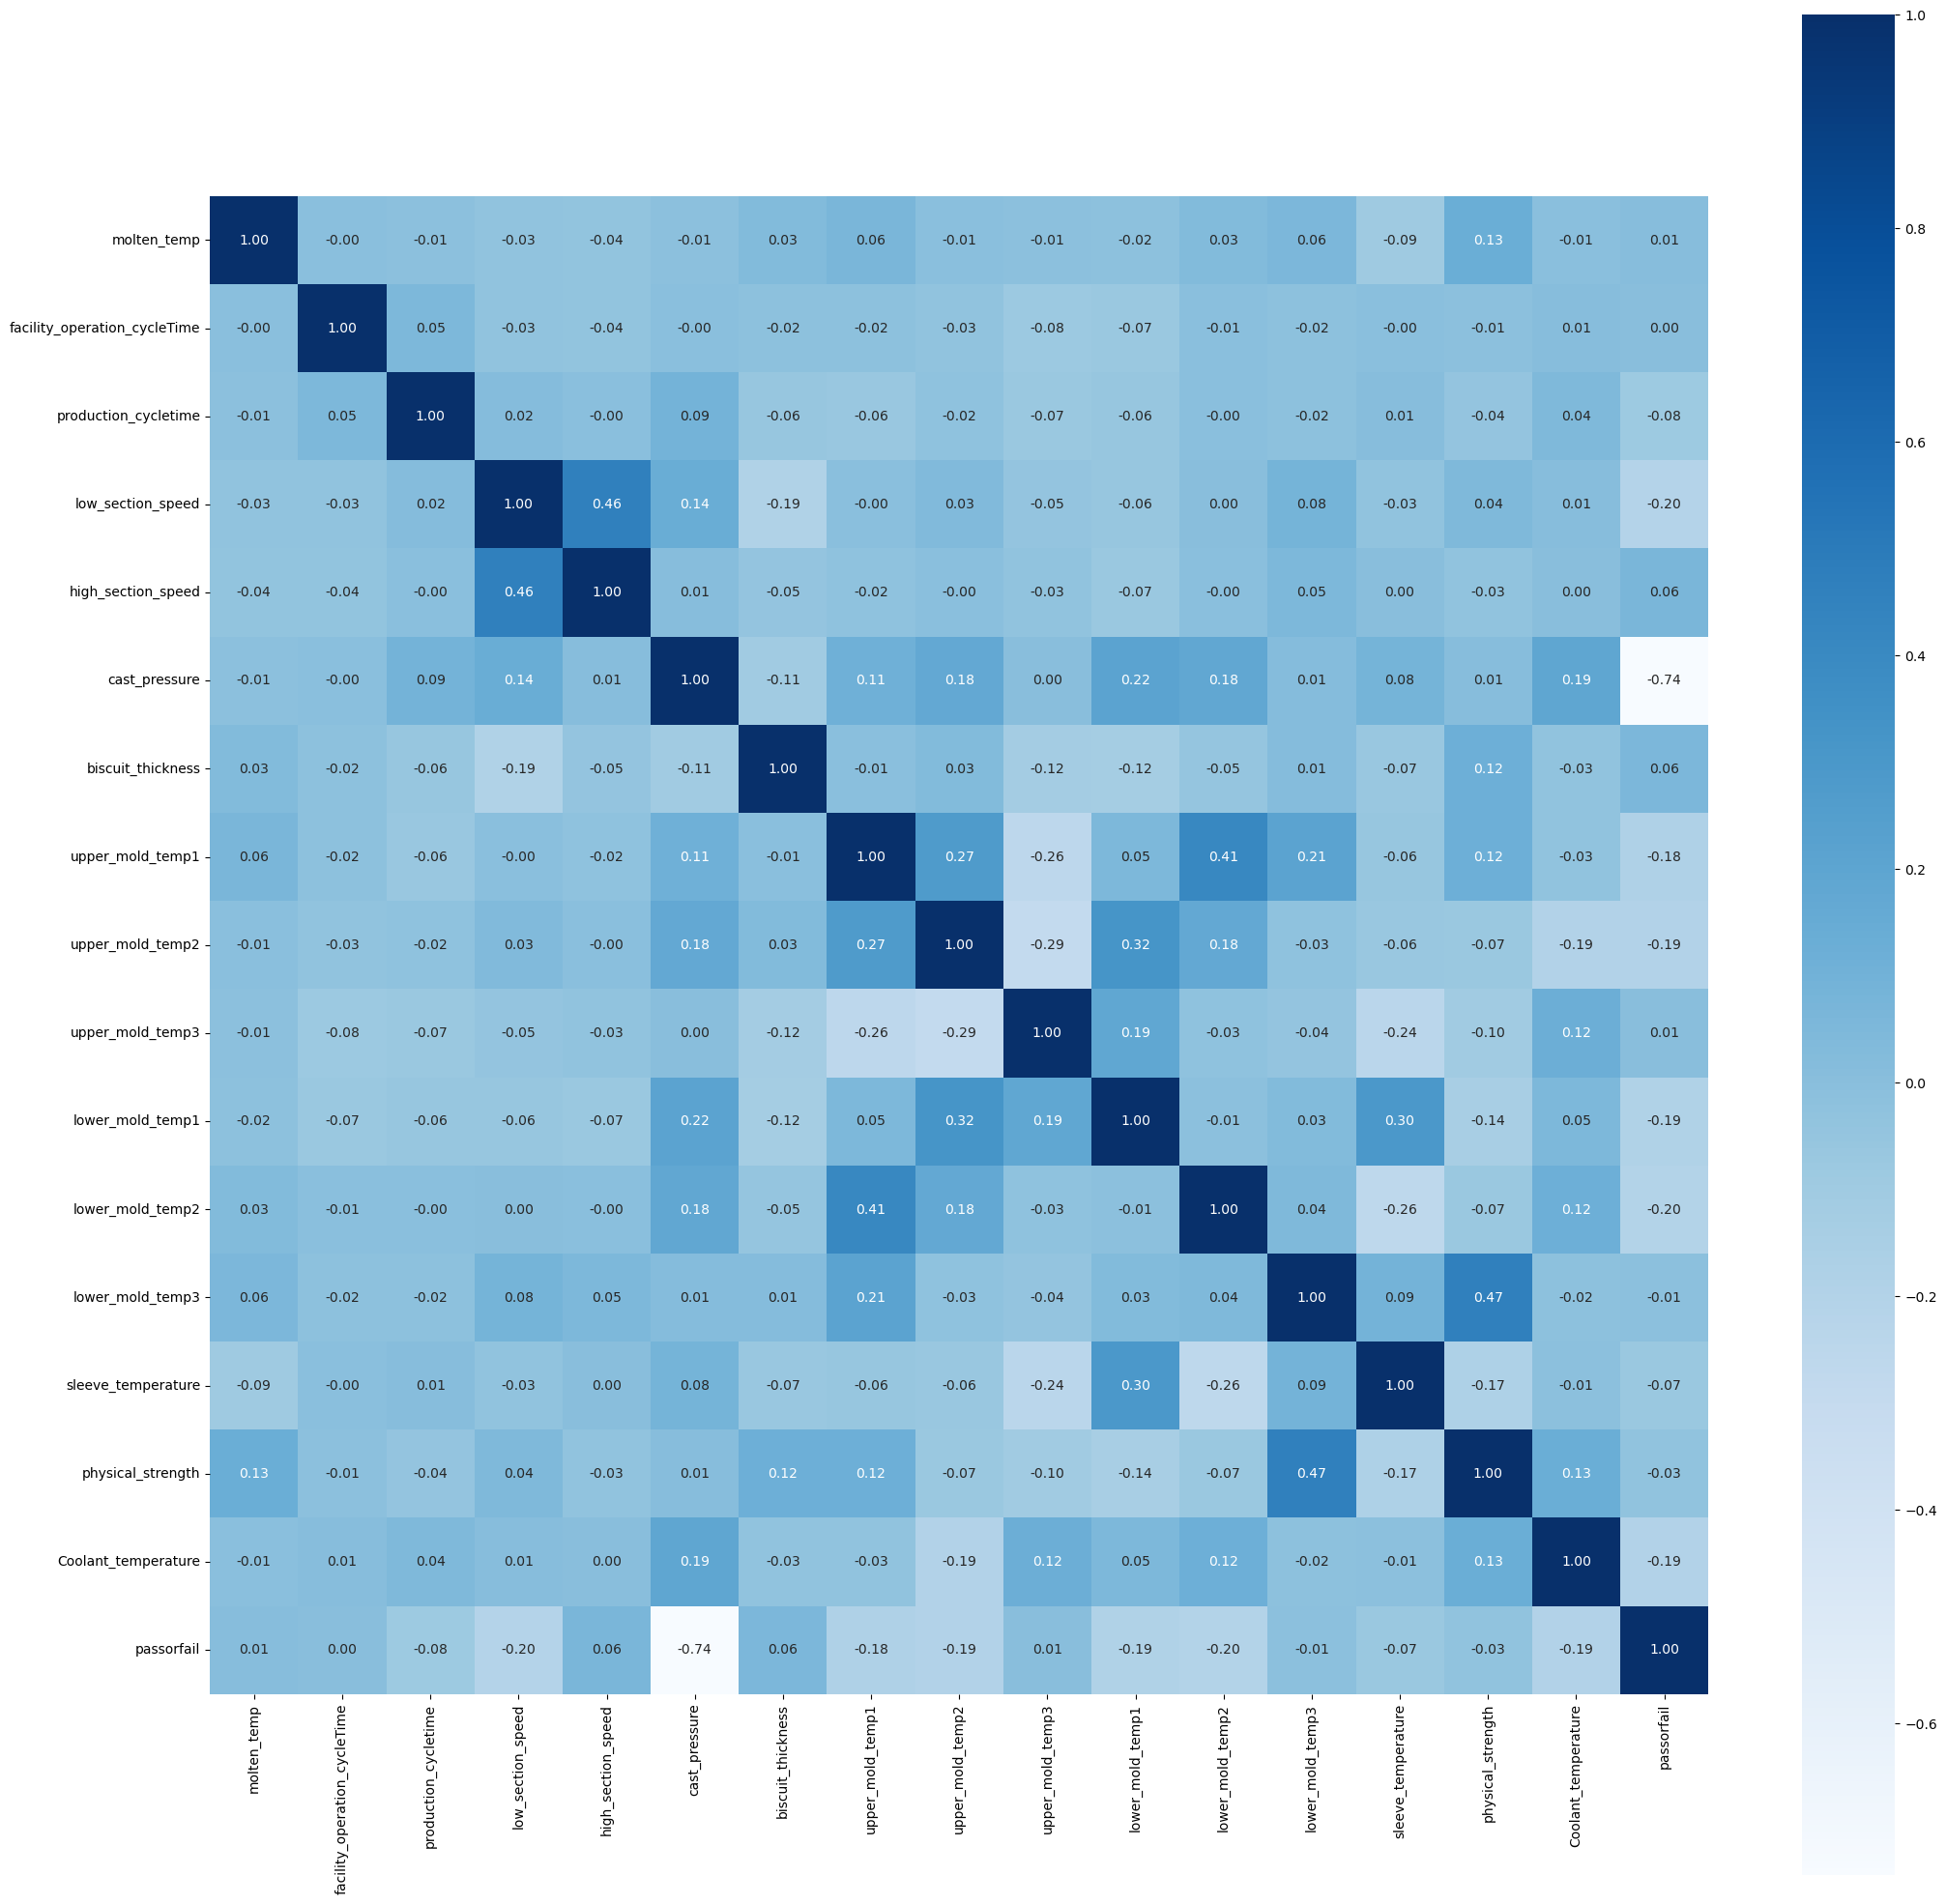

In [165]:
plt.figure(figsize=(25,25))
sns.heatmap(df_done.corr(), annot=True, fmt='.2f', square=True, cmap='Blues')
plt.show()

- passorfail과 cast_pressure의 상관계수는 0.7로 매우 높은 음의 상관관계를 보이며 
- high_section_speed와 low_section_speed는 0.5로 높은 양의 상관관계를 보인다.


- 알고리즘 선택

In [166]:
X = df_done.drop('passorfail', axis=1).values
y = df_done['passorfail'].values

In [167]:
# 불량률이 3%에 불과한 데이터에 대해 분할 split마다 양품과 불량이 균등한 비율로 구성되도록 StratifiedShuffleSplit을 적용
sss = StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2)

In [125]:
# 0~1사이로 정규화
# 데이터 정규화를 하는 이유는 각 변수별로 값의 범위가 다르게 되면
# 모델은 크기가 큰 변수에 영향을 많이 받게 되어 부정확한 모델이 생성
mms = MinMaxScaler()

In [126]:
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42, eval_metric='error', use_label_encoder=False)
lgbm_clf = LGBMClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

- DecisionTree

In [127]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_fold_f1 = []
n_iter = 0
print('모델 :', dt_clf)
idx_list = [] 
for train_idx, test_idx in sss.split(X, y):
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]
 
  for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    dt_clf.fit(X_train_scaled, y_train)
    valid_pred = dt_clf.predict(X_valid_scaled)
    test_pred = dt_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    valid_CR = classification_report(y_valid, valid_pred)
    test_CR = classification_report(y_test, test_pred)
    n_iter += 1
    dt_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
  print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 report : {valid_CR}')
  print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 report : {test_CR}')
  print('='*50)
  dt_fold_f1.sort(key=lambda x : x[1], reverse=True)
  print(f'교차검증 중 가장 높은 정확도 : Split {dt_fold_f1[0][0]} {dt_fold_f1[0][1]}')

모델 : DecisionTreeClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 report :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13483
         1.0       1.00      1.00      1.00       479

    accuracy                           1.00     13962
   macro avg       1.00      1.00      1.00     13962
weighted avg       1.00      1.00      1.00     13962

StratifiedShuffleSplit 5 테스트 데이터 report :               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     16854
         1.0       0.84      0.84      0.84       598

    accuracy                           0.99     17452
   macro avg       0.92      0.92      0.92     17452
weighted avg       0.99      0.99      0.99     17452

교차검증 중 가장 높은 정확도 : Split 1 0.8402662229617305
StratifiedShuffleSplit 10 검증 데이터 report :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13483
         1.0       1.

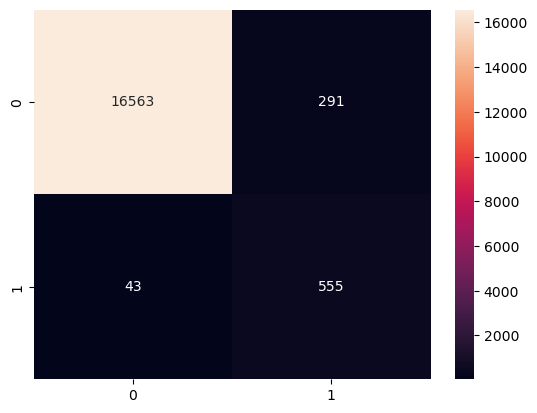

In [130]:
dt_clf.fit(X[idx_list[dt_fold_f1[0][0]-1][0]], y[idx_list[dt_fold_f1[0][0]-1][0]])
pred = dt_clf.predict(X[idx_list[dt_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[dt_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- RandomForest

In [132]:
rf_clf = RandomForestClassifier(random_state=42)
rf_fold_f1 = []
n_iter = 0
print('모델 :', rf_clf)
idx_list = [] 
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]
 
 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    rf_clf.fit(X_train_scaled, y_train)
    valid_pred = rf_clf.predict(X_valid_scaled)
    test_pred = rf_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    rf_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 dt_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {rf_fold_f1[0][0]} {rf_fold_f1[0][1]}')

모델 : RandomForestClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.8908450704225352
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 10 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 10 테스트 데이터 f1 정확도 : 0.8805704099821747
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 15 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 15 테스트 데이터 f1 정확도 : 0.87151841868823
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 20 검증 데이터 f1 정확도 : 0.9989550679205852
StratifiedShuffleSplit 20 테스트 데이터 f1 정확도 : 0.8780053428317008
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 25 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 25 테스트 데이터 f1 정확도 : 0.8760180995475113
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352


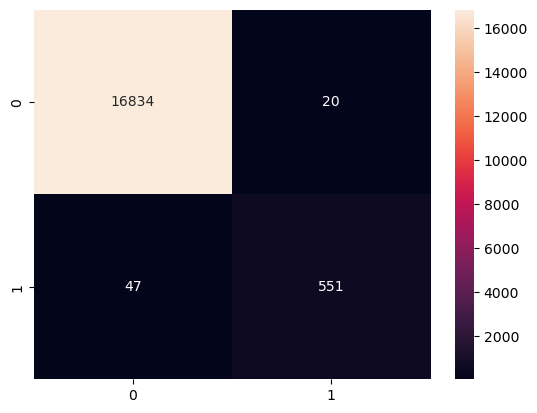

In [133]:
rf_clf.fit(X[idx_list[rf_fold_f1[0][0]-1][0]], y[idx_list[rf_fold_f1[0][0]-1][0]])
pred = rf_clf.predict(X[idx_list[rf_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[rf_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- XGBoost

In [134]:
xgb_clf = RandomForestClassifier(random_state=42)
xgb_fold_f1 = []
n_iter = 0
print('모델 :', xgb_clf)
idx_list = [] 
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]
 
 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    xgb_clf.fit(X_train_scaled, y_train)
    valid_pred = xgb_clf.predict(X_valid_scaled)
    test_pred = xgb_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    xgb_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 xgb_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {xgb_fold_f1[0][0]} {xgb_fold_f1[0][1]}')

모델 : RandomForestClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.8908450704225352
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 10 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 10 테스트 데이터 f1 정확도 : 0.8805704099821747
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 15 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 15 테스트 데이터 f1 정확도 : 0.87151841868823
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 20 검증 데이터 f1 정확도 : 0.9989550679205852
StratifiedShuffleSplit 20 테스트 데이터 f1 정확도 : 0.8780053428317008
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352
StratifiedShuffleSplit 25 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 25 테스트 데이터 f1 정확도 : 0.8760180995475113
교차검증 중 가장 높은 정확도 : Split 1 0.8908450704225352


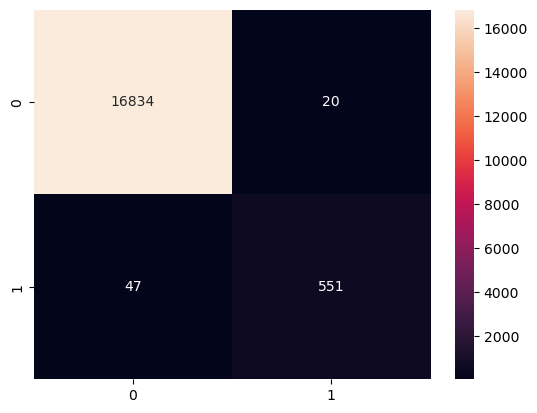

In [135]:
xgb_clf.fit(X[idx_list[xgb_fold_f1[0][0]-1][0]], y[idx_list[xgb_fold_f1[0][0]-1][0]])
pred = xgb_clf.predict(X[idx_list[xgb_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[xgb_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- LightGBM

In [136]:
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_fold_f1 = []
n_iter = 0
print('모델 :', lgbm_clf)
idx_list = [] 
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]
 
 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    lgbm_clf.fit(X_train_scaled, y_train)
    valid_pred = lgbm_clf.predict(X_valid_scaled)
    test_pred = lgbm_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    lgbm_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 lgbm_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {lgbm_fold_f1[0][0]} {lgbm_fold_f1[0][1]}')

모델 : LGBMClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 0.9591397849462365
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.893542757417103
교차검증 중 가장 높은 정확도 : Split 1 0.893542757417103
StratifiedShuffleSplit 10 검증 데이터 f1 정확도 : 0.9624060150375939
StratifiedShuffleSplit 10 테스트 데이터 f1 정확도 : 0.8796536796536797
교차검증 중 가장 높은 정확도 : Split 1 0.893542757417103
StratifiedShuffleSplit 15 검증 데이터 f1 정확도 : 0.9671261930010604
StratifiedShuffleSplit 15 테스트 데이터 f1 정확도 : 0.8804920913884007
교차검증 중 가장 높은 정확도 : Split 1 0.893542757417103
StratifiedShuffleSplit 20 검증 데이터 f1 정확도 : 0.9678800856531049
StratifiedShuffleSplit 20 테스트 데이터 f1 정확도 : 0.8767605633802817
교차검증 중 가장 높은 정확도 : Split 1 0.893542757417103
StratifiedShuffleSplit 25 검증 데이터 f1 정확도 : 0.975557917109458
StratifiedShuffleSplit 25 테스트 데이터 f1 정확도 : 0.8680926916221033
교차검증 중 가장 높은 정확도 : Split 1 0.893542757417103


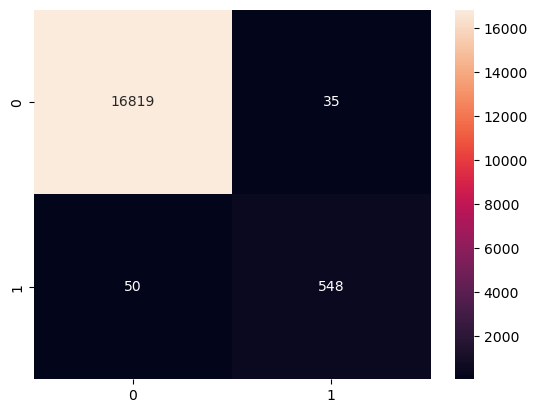

In [137]:
lgbm_clf.fit(X[idx_list[lgbm_fold_f1[0][0]-1][0]], y[idx_list[lgbm_fold_f1[0][0]-1][0]])
pred = lgbm_clf.predict(X[idx_list[lgbm_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- AdaBoost

In [142]:
ada_clf = AdaBoostClassifier(random_state=42)
ada_fold_f1 = []
n_iter = 0
print('모델 :', ada_clf)
idx_list = [] 
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]
 
 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    ada_clf.fit(X_train_scaled, y_train)
    valid_pred = ada_clf.predict(X_valid_scaled)
    test_pred = ada_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    ada_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 lgbm_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {ada_fold_f1[0][0]} {ada_fold_f1[0][1]}')

모델 : AdaBoostClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 0.7606318347509113
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.8072174738841406
교차검증 중 가장 높은 정확도 : Split 1 0.8072174738841406
StratifiedShuffleSplit 10 검증 데이터 f1 정확도 : 0.7980769230769231
StratifiedShuffleSplit 10 테스트 데이터 f1 정확도 : 0.8011152416356877
교차검증 중 가장 높은 정확도 : Split 1 0.8072174738841406
StratifiedShuffleSplit 15 검증 데이터 f1 정확도 : 0.815242494226328
StratifiedShuffleSplit 15 테스트 데이터 f1 정확도 : 0.7886255924170616
교차검증 중 가장 높은 정확도 : Split 1 0.8072174738841406
StratifiedShuffleSplit 20 검증 데이터 f1 정확도 : 0.823803967327888
StratifiedShuffleSplit 20 테스트 데이터 f1 정확도 : 0.7924170616113744
교차검증 중 가장 높은 정확도 : Split 1 0.8072174738841406
StratifiedShuffleSplit 25 검증 데이터 f1 정확도 : 0.7897310513447433
StratifiedShuffleSplit 25 테스트 데이터 f1 정확도 : 0.763671875
교차검증 중 가장 높은 정확도 : Split 1 0.8072174738841406


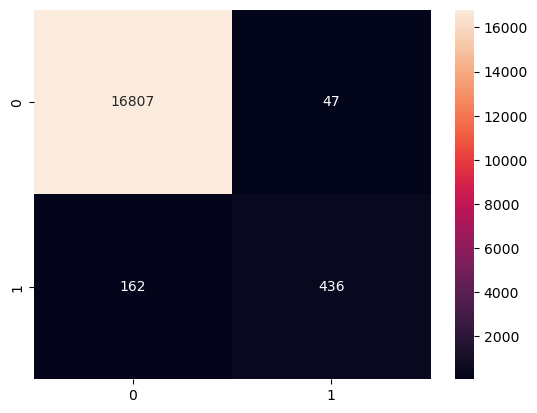

In [143]:
ada_clf.fit(X[idx_list[ada_fold_f1[0][0]-1][0]], y[idx_list[ada_fold_f1[0][0]-1][0]])
pred = ada_clf.predict(X[idx_list[ada_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[ada_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

In [172]:
from catboost import CatBoostClassifier
cat_clf = CatBoostClassifier(random_state=42)
cat_fold_f1 = []
n_iter = 0
print('모델 :', cat_clf)
idx_list = [] 
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]
 
 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    cat_clf.fit(X_train_scaled, y_train)
    valid_pred = cat_clf.predict(X_valid_scaled)
    test_pred = cat_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    cat_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 lgbm_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {cat_fold_f1[0][0]} {cat_fold_f1[0][1]}')

모델 : <catboost.core.CatBoostClassifier object at 0x000001A75DA78160>
Learning rate set to 0.063136
0:	learn: 0.5627345	total: 165ms	remaining: 2m 44s
1:	learn: 0.4660569	total: 180ms	remaining: 1m 29s
2:	learn: 0.3873936	total: 195ms	remaining: 1m 4s
3:	learn: 0.3160684	total: 212ms	remaining: 52.7s
4:	learn: 0.2650826	total: 227ms	remaining: 45.2s
5:	learn: 0.2250613	total: 243ms	remaining: 40.2s
6:	learn: 0.1916020	total: 258ms	remaining: 36.6s
7:	learn: 0.1646360	total: 272ms	remaining: 33.8s
8:	learn: 0.1438210	total: 288ms	remaining: 31.7s
9:	learn: 0.1283924	total: 303ms	remaining: 30s
10:	learn: 0.1152295	total: 317ms	remaining: 28.5s
11:	learn: 0.1038611	total: 331ms	remaining: 27.3s
12:	learn: 0.0944349	total: 359ms	remaining: 27.3s
13:	learn: 0.0868069	total: 374ms	remaining: 26.3s
14:	learn: 0.0804935	total: 389ms	remaining: 25.5s
15:	learn: 0.0759766	total: 408ms	remaining: 25.1s
16:	learn: 0.0721658	total: 426ms	remaining: 24.6s
17:	learn: 0.0687302	total: 440ms	remaining:

Learning rate set to 0.057398
0:	learn: 0.5706752	total: 14.8ms	remaining: 14.8s
1:	learn: 0.4797825	total: 27.8ms	remaining: 13.9s
2:	learn: 0.4039491	total: 40.5ms	remaining: 13.4s
3:	learn: 0.3326789	total: 54.2ms	remaining: 13.5s
4:	learn: 0.2810677	total: 67.9ms	remaining: 13.5s
5:	learn: 0.2410018	total: 80.7ms	remaining: 13.4s
6:	learn: 0.2084350	total: 93.7ms	remaining: 13.3s
7:	learn: 0.1788072	total: 107ms	remaining: 13.3s
8:	learn: 0.1562439	total: 120ms	remaining: 13.2s
9:	learn: 0.1393028	total: 134ms	remaining: 13.2s
10:	learn: 0.1250417	total: 147ms	remaining: 13.2s
11:	learn: 0.1125707	total: 160ms	remaining: 13.2s
12:	learn: 0.1025806	total: 173ms	remaining: 13.1s
13:	learn: 0.0943940	total: 186ms	remaining: 13.1s
14:	learn: 0.0868768	total: 201ms	remaining: 13.2s
15:	learn: 0.0812502	total: 221ms	remaining: 13.6s
16:	learn: 0.0765166	total: 236ms	remaining: 13.7s
17:	learn: 0.0721122	total: 251ms	remaining: 13.7s
18:	learn: 0.0677757	total: 266ms	remaining: 13.7s
19:	

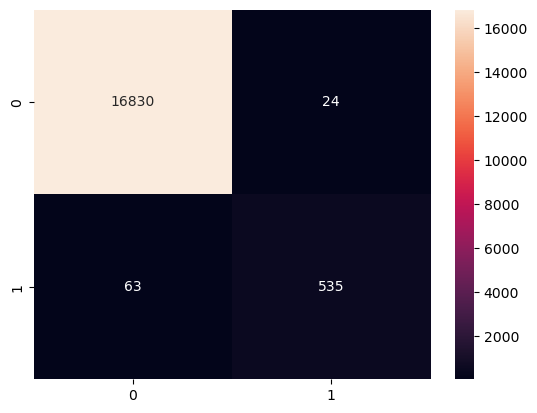

In [173]:
cat_clf.fit(X[idx_list[cat_fold_f1[0][0]-1][0]], y[idx_list[cat_fold_f1[0][0]-1][0]])
pred = cat_clf.predict(X[idx_list[cat_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[cat_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- LightGBM Permutation Imoprtance

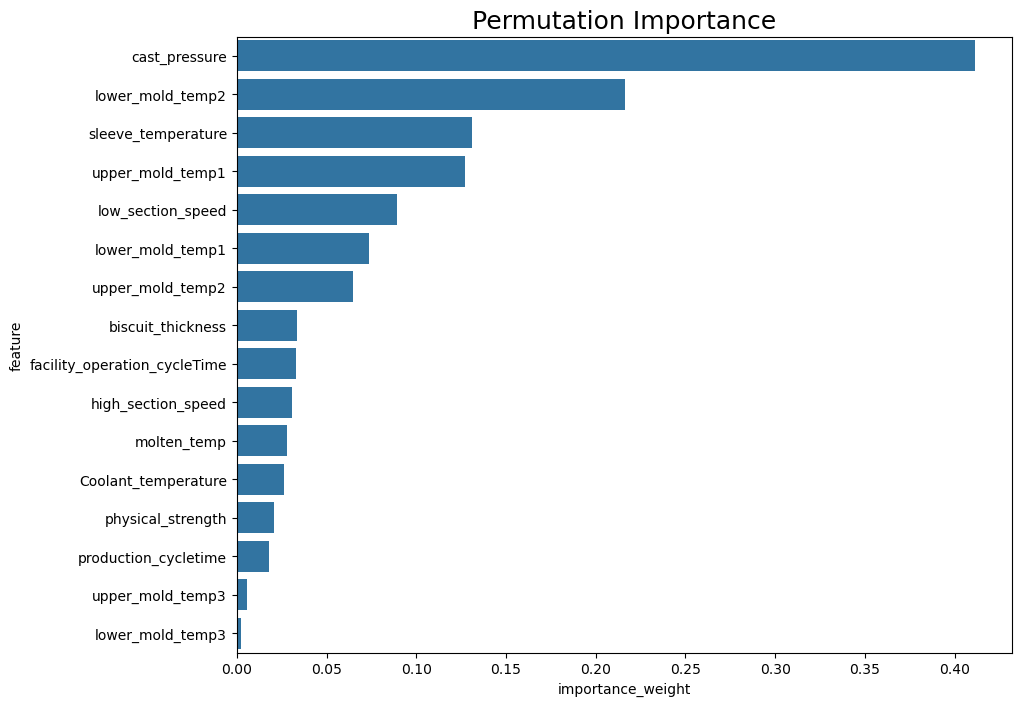

In [174]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(
    estimator=lgbm_clf,
    X=X[idx_list[lgbm_fold_f1[0][0]-1][0]],
    y=y[idx_list[lgbm_fold_f1[0][0]-1][0]],
    scoring='f1',
    n_repeats=30
)

# Create a DataFrame with feature importances
permu_df = pd.DataFrame()
permu_df["feature"] = df_done.columns[:-1]
permu_df["importance_weight"] = pi.importances_mean
permu_df.sort_values(by='importance_weight', ascending=False, inplace=True)
permu_df.reset_index(drop=True, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance_weight', y='feature', data=permu_df)
plt.title('Permutation Importance', fontsize=18)
plt.show()

- LGBM 모델 트리 시각화 및 최적화

<Axes: >

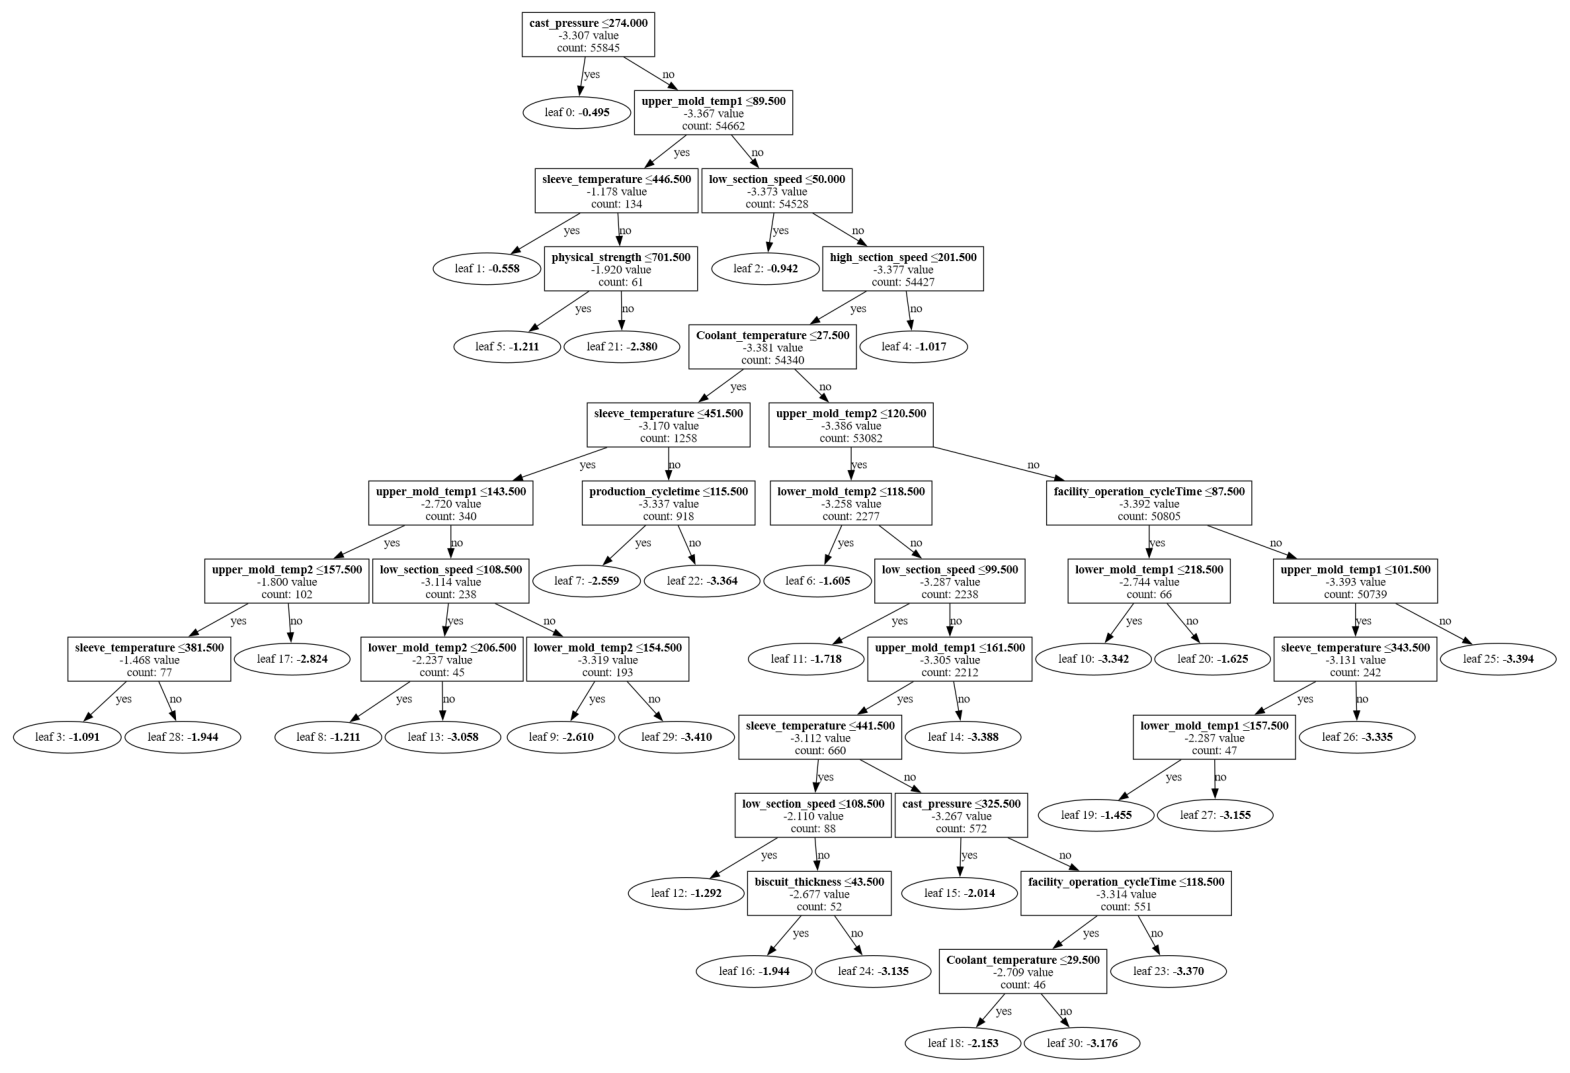

In [171]:
lgbm = LGBMClassifier(random_state=42)
tmp = pd.DataFrame(X[idx_list[lgbm_fold_f1[0][0]-1][0]], columns=df_done.columns[:-1])
lgbm.fit(tmp, y[idx_list[lgbm_fold_f1[0][0]-1][0]])
lightgbm.plot_tree(lgbm,dpi=100,orientation='vertical',figsize=(20,15), show_info=['internal_value', 'internal_count'])